# Task a) and b) of Project 1 - FYS-STK4155

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold

import matplotlib.style as mplstyle
mplstyle.use(['ggplot', 'fast'])

# plt.rcParams.update({
#     "text.usetex": True,       
#     "font.family": "serif",    
#     "font.size": 10, 
# })


# For reproducibility
np.random.seed(2018)
seed = np.random.seed(2018)

In [148]:
# --- General functions ---

def f_true(x): 
    '''
    Return 1D Runge function
    '''  
    return 1.0 / (1.0 + 25.0 * x**2)  # Runge-lignende funksjon

def make_data(n, seed=seed):     
    '''
    Makes a data set of length n over the Runge function
    for x in (-1, 1).

    Creates train and test data sets
    '''
    x = np.linspace(-1, 1, n)   

    y_clean = f_true(x)    
    y = y_clean + np.random.normal(0, 0.1, n)

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=seed, shuffle=True
    )

    train = (x_train, y_train)
    test  = (x_test, y_test)
    full  = (x, y, y_clean)
    return train, test, full

In [149]:
# --- Part a) ---
def OLS_results(n_vals, p_vals):
    '''
    Perform Ordinary Least Squares (OLS) regression on the Runge function
    for multiple dataset sizes and polynomial degrees, and return evaluation results.

    Parameters
    ----------
    n_vals : np.ndarray
        A list of integers specifying the number of data points to generate for each dataset.
    p_vals : np.ndarray
        A list of integers specifying the polynomial degrees to fit using OLS.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the results for each combination of dataset size and polynomial degree,
        with the following columns:
        - 'n': Number of data points.
        - 'p': Polynomial degree used in OLS.
        - 'theta': Coefficients of the fitted polynomial model.
        - 'MSE': Mean squared error on the test set.
        - 'R2': R-squared score on the test set.
        - 'y_pred': Predicted values on the test set.
        - 'y_test': True values on the test set.
        - 'y_train': Training set target values.
        - 'y_all': Full dataset target values (including noise).
        - 'x_test': Test set input features.
        - 'x_train': Training set input features.
        - 'x_all': Full dataset input features.

    Notes
    -----
    - The function uses `make_data(n)` to generate a dataset of size `n` from the Runge function.
    - OLS is performed via a pipeline of `PolynomialFeatures`, `StandardScaler`, and `LinearRegression`,
        which are functions from sklearn module.
    - `StandardScaler` is used without mean centering (`with_mean=False`) since the model is fitted without intercept.
    '''

    results = []

    for n in n_vals:
        train, test, full = make_data(n)  # making a dataset with size n
        x_train, y_train = train  # training data
        x_test, y_test = test  # test data
        x_all, y_all, y_all_clean = full  # actual data

        x_train = x_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)
        x_all = x_all.reshape(-1, 1)

        # making an OLS model for a given polynomial degree, p
        for p in p_vals:
            model = make_pipeline(
                PolynomialFeatures(degree=p, include_bias=True),
                StandardScaler(with_mean=False),
                LinearRegression(fit_intercept=False)
            )
        
            # using the training data to train the model
            model.fit(x_train, y_train)

            # using the test data to make a prediction, unsee data for the model
            y_pred_test = model.predict(x_test)
            y_pred_train = model.predict(x_train)
        
            # assessing the model with scores
            mse_test = mean_squared_error(y_test, y_pred_test)
            r2_test = r2_score(y_test, y_pred_test)

            mse_train = mean_squared_error(y_train, y_pred_train)
            r2_train = r2_score(y_train, y_pred_train)


            # extracting the model features
            theta = model.named_steps['linearregression'].coef_
        
            # saving the results in a pandas dataframe
            results.append({
                'n': n,
                'p': p,
                'theta': theta,
                'MSE_test': mse_test,
                'R2_test': r2_test,
                'MSE_train': mse_train,
                'R2_train': r2_train,
                'y_pred_test': y_pred_test,
                'y_pred_train': y_pred_train,
                'y_test': y_test,
                'y_train': y_train,
                'y_all': y_all,
                'x_test': x_test,
                'x_train': x_train,
                'x_all': x_all
            })

    df_OLS = pd.DataFrame(results)

    return df_OLS

def plot_OLS_results(df_OLS, n, p):
    """
    Plot the OLS results for a specific number of datapoints 'n' and polynomial degree `p`.
    """
    row = df_OLS[(df_OLS['n'] == n) & (df_OLS['p'] == p)].iloc[0]

    x_train = row['x_train']
    y_train = row['y_train']
    x_test = row['x_test']
    y_test = row['y_test']
    x_all = row['x_all']
    y_all = row['y_all']
    y_pred_test = row['y_pred_test']
    y_pred_train = row['y_pred_train']

    plt.figure(figsize=(8, 5))

    # Plot actual data
    plt.scatter(x_all, y_all, s=6, label='Actual data')

    # Plot training data
    plt.scatter(x_train, y_train, s=6, label='Training data')

    # Plot test data
    plt.scatter(x_test, y_test, s=6, label='Test data')

    # Plot model prediction on test data
    plt.scatter(x_test, y_pred_test, s=6, label='Predicted (test)')

    # Plot model prediction on test data
    plt.scatter(x_train, y_pred_train, s=6, label='Predicted (train)')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'OLS Polynomial Regression (n={n}, p={p})')
    plt.legend()
    plt.show()


# --- Part b) ---
def Ridge_results(n_vals, p_vals, lambdas):
    '''
    Perform Ridge regression on the Runge function
    for multiple dataset sizes, penalization parameter and polynomial degrees, and return evaluation results.

    Parameters
    ----------
    n_vals : np.ndarray
        A list of integers specifying the number of data points to generate for each dataset.
    p_vals : np.ndarray
        A list of integers specifying the polynomial degrees to fit using OLS.
    lambdas: np.ndarray
        A list of floats specifying the penalization parameter for Ridge.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the results for each combination of dataset size and polynomial degree,
        with the following columns:
        - 'n': Number of data points.
        - 'p': Polynomial degree used in Ridge.
        - 'lambda': Hyperparameter for Ridge
        - 'theta': Coefficients of the fitted polynomial model.
        - 'MSE': Mean squared error on the test set.
        - 'R2': R-squared score on the test set.
        - 'y_pred': Predicted values on the test set.
        - 'y_test': True values on the test set.
        - 'y_train': Training set target values.
        - 'y_all': Full dataset target values (including noise).
        - 'x_test': Test set input features.
        - 'x_train': Training set input features.
        - 'x_all': Full dataset input features.

    Notes
    -----
    - The function uses `make_data(n)` to generate a dataset of size `n` from the Runge function.
    - Ridge is performed via a pipeline of `PolynomialFeatures`, `StandardScaler`, and `LinearRegression`,
        which are functions from sklearn module.
    - `StandardScaler` is used without mean centering (`with_mean=False`) since the model is fitted without intercept.
    '''
    results = []

    for n in n_vals:
        train, test, full = make_data(n)  # making a dataset with size n
        x_train, y_train = train
        x_test, y_test = test
        x_all, y_all, y_all_clean = full

        x_train = x_train.reshape(-1, 1)
        x_test = x_test.reshape(-1, 1)
        x_all = x_all.reshape(-1, 1)

        for p in p_vals:
            for l in lambdas:
                model = make_pipeline(
                    PolynomialFeatures(degree=p, include_bias=True),
                    StandardScaler(with_mean=False),
                    Ridge(alpha=l, fit_intercept=False)
                )
        
                model.fit(x_train, y_train)
                y_pred = model.predict(x_test)

                mse = mean_squared_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)

                theta = model.named_steps['ridge'].coef_

                results.append({
                    'n': n,
                    'p': p,
                    'lambda': l, 
                    'theta': theta,
                    'MSE': mse,
                    'R2': r2,
                    'y_pred': y_pred,
                    'y_test': y_test,
                    'y_train': y_train,
                    'y_all': y_all,
                    'x_test': x_test,
                    'x_train': x_train,
                    'x_all': x_all
                })

    df_Ridge = pd.DataFrame(results)
    return df_Ridge

def plot_Ridge_results(df_Ridge, n, p, l):
    '''
    Plot Ridge regression results for specific number of data points 'n', polynomial degree 'p', and lambda 'l'.
    '''
    row = df_Ridge[(df_Ridge['n'] == n) & (df_Ridge['p'] == p) & (df_Ridge['lambda'] == l)].iloc[0]

    x_train = row['x_train']
    y_train = row['y_train']
    x_test = row['x_test']
    y_test = row['y_test']
    x_all = row['x_all']
    y_all = row['y_all']
    y_pred = row['y_pred']

    plt.figure(figsize=(8, 5))

    # Plot actual data
    plt.scatter(x_all, y_all, s=6, label='Actual data')

    # Plot training data
    plt.scatter(x_train, y_train, s=6, label='Training data')

    # Plot test data
    plt.scatter(x_test, y_test, s=6, label='Test data')

    # Plot predicted test values
    plt.scatter(x_test, y_pred, s=6, label='Predicted (test)')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(rf'Ridge Regression (n={n}, p={p}, $\lambda$={l:.2e})')
    plt.legend()
    plt.show()

# Over her tilhører functions!

* 1) velg en n, finn beste p
* 2) for beste p, lek med n


prøv for mye høyere p!!!

In [150]:
""" from functions import *

%load_ext autoreload
%autoreload 2 """

' from functions import *\n\n%load_ext autoreload\n%autoreload 2 '

In [151]:
# Colormap for plotting
colormap = 'plasma'

# a) Ordinary Least Squares (OLS)
* Using OLS to predict the Runge function.
* Method is applied for the different number of data points in `n_vals` and for the different polynomial degrees in `p_vals`.
* Uses sklearn functionalities to make the model and assess the MSE and R^2 score.

In [152]:
n_vals = np.arange(50, 2250, 200)  # Range of number of data points, 50-2050
p_vals = np.arange(2, 16)  # Range of polynomial degrees, 2-15

In [153]:
df_OLS = OLS_results(n_vals, p_vals)

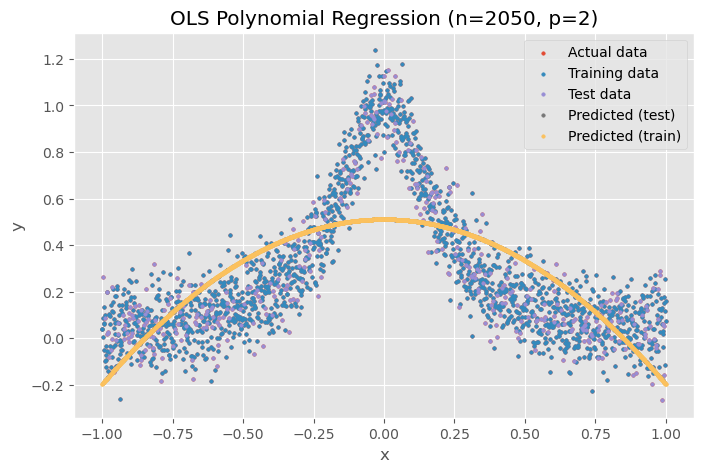

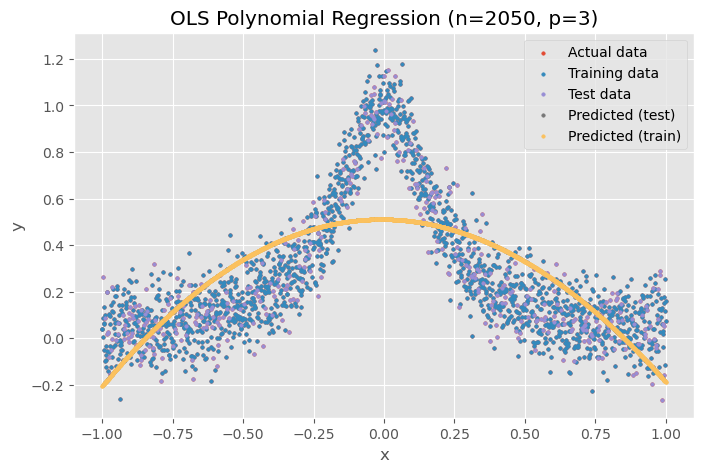

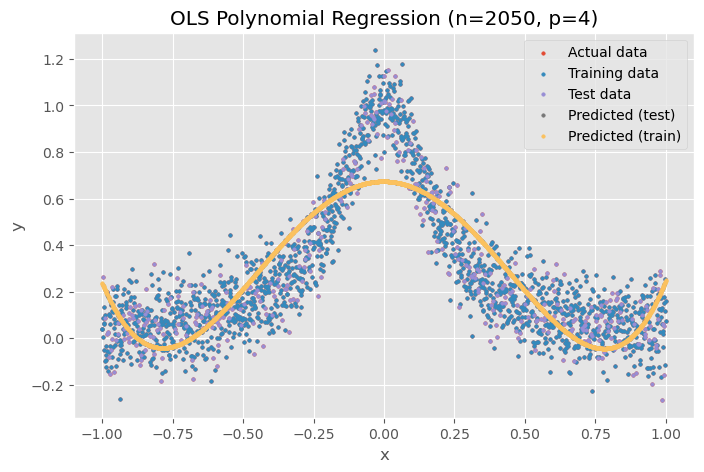

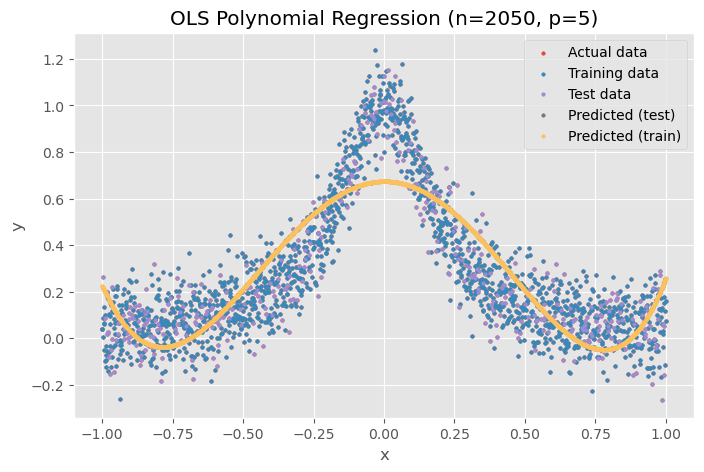

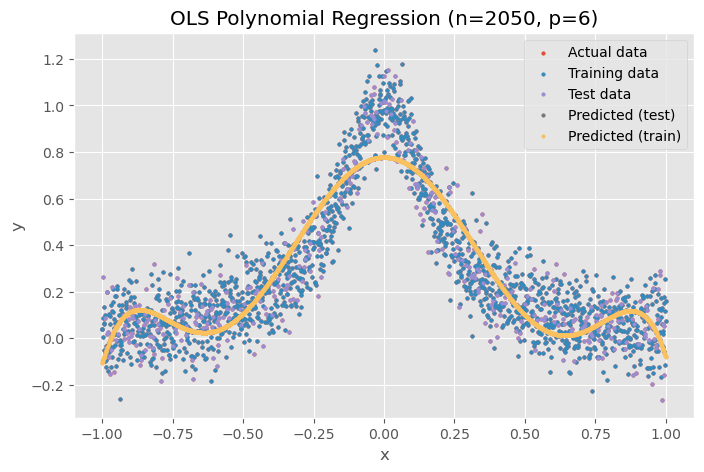

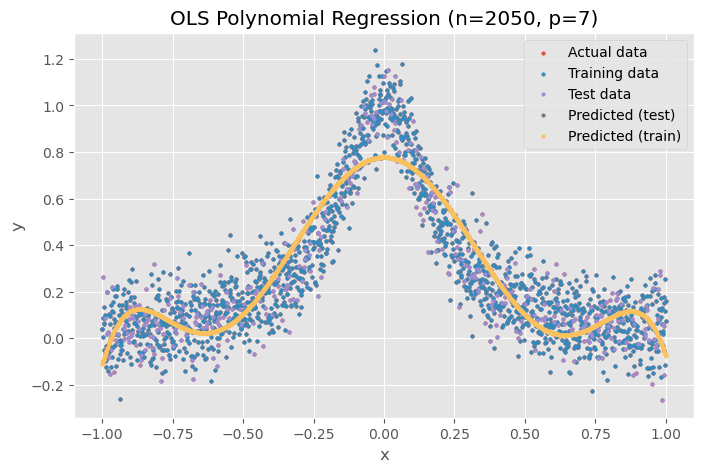

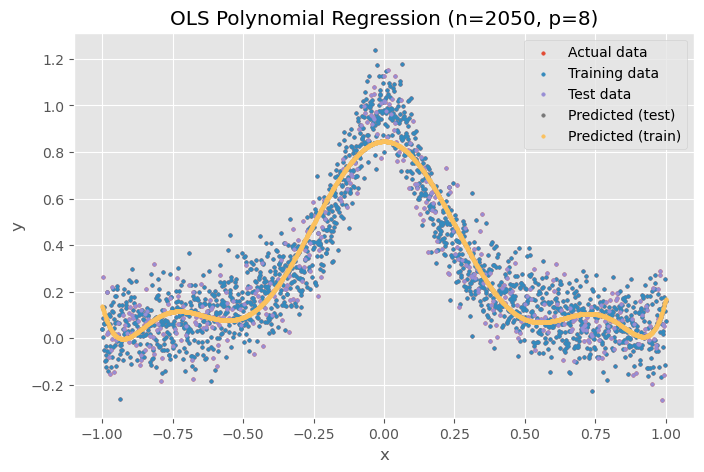

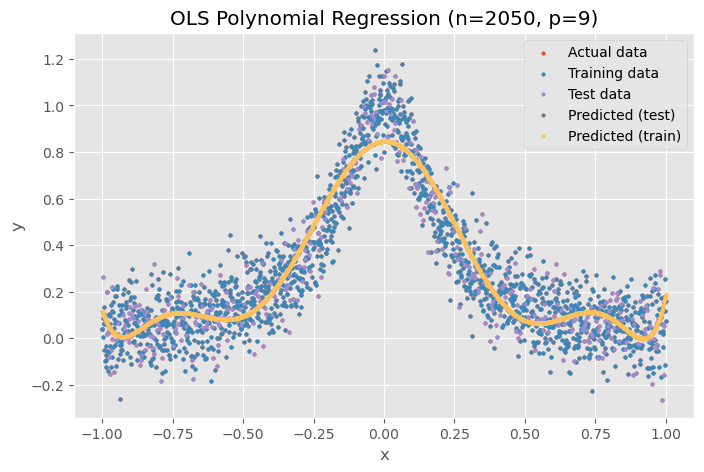

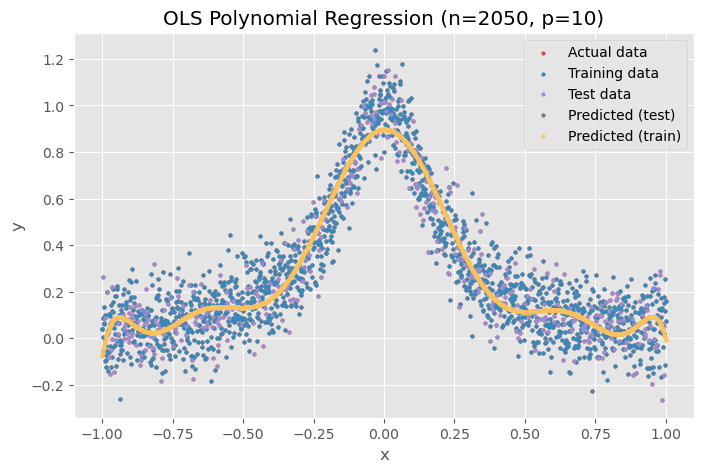

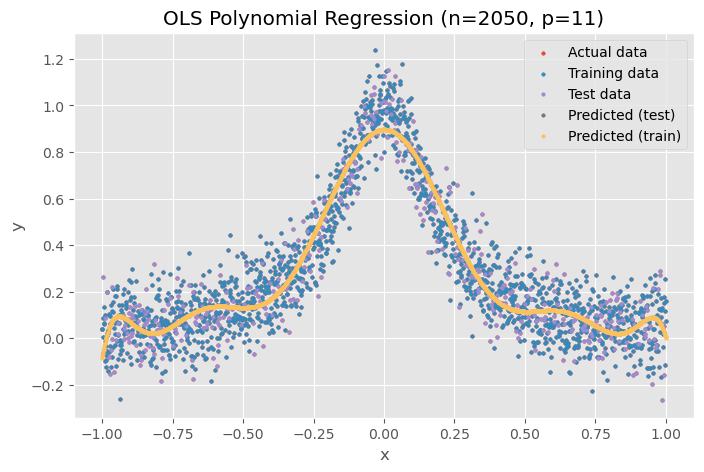

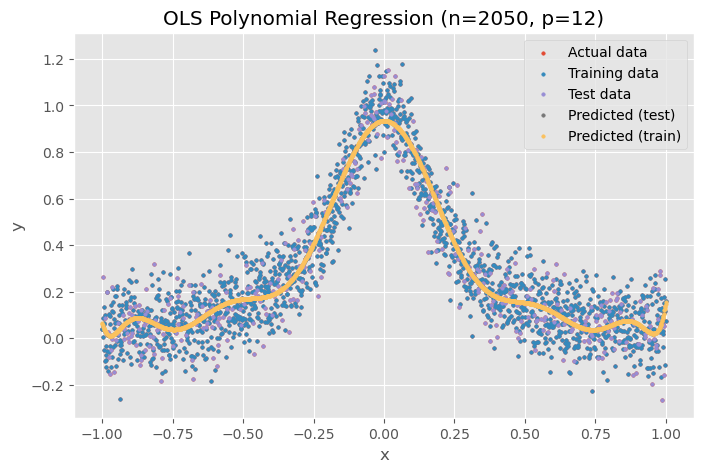

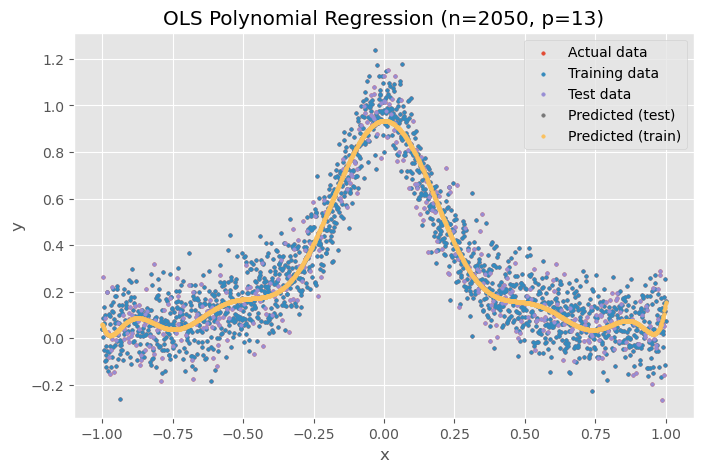

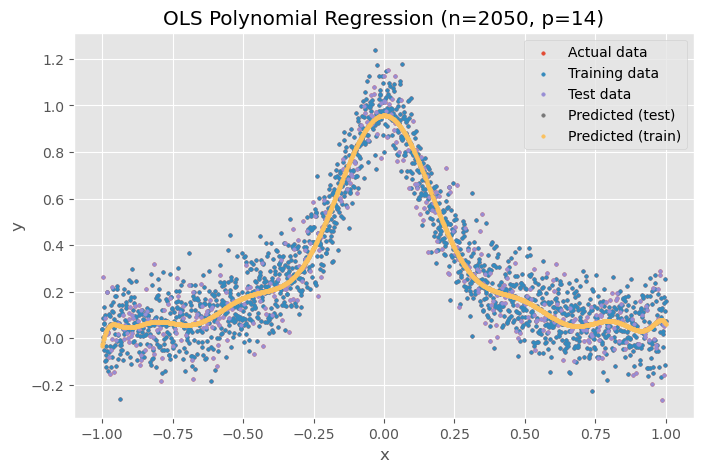

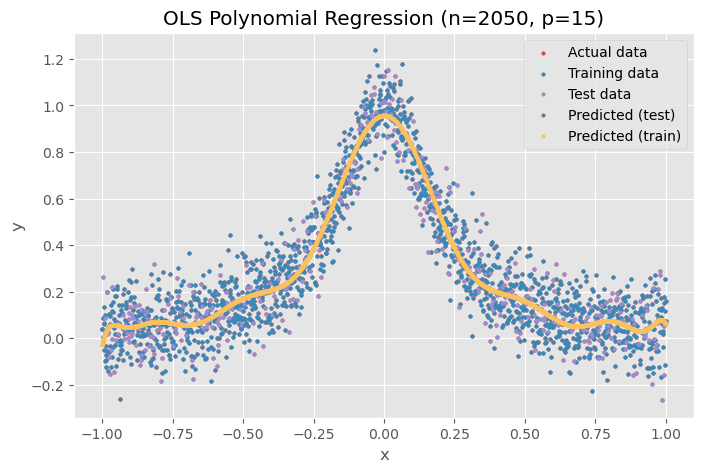

In [154]:
for p in p_vals:
    plot_OLS_results(df_OLS, n_vals[-1], p)

* Oscillations for larger polynomial degrees, as expected.

Text(0.5, 0.98, 'OLS (test)')

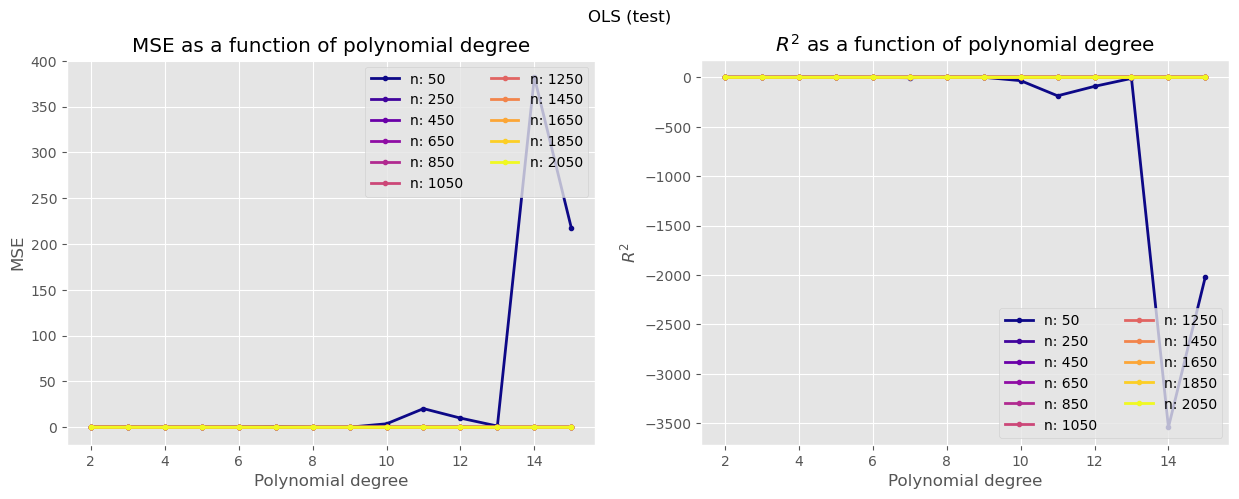

In [155]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

num_colors = len(n_vals)
cmap = plt.get_cmap(colormap, num_colors)

for i, en in enumerate(n_vals):
    n_df = df_OLS[df_OLS['n'] == en]
    color = cmap(i) 
    ax[0].plot(n_df['p'], n_df['MSE_test'], marker='o', markersize='3', linewidth='2', color=color, label=f'n: {en}')


ax[0].set_title('MSE as a function of polynomial degree')
ax[0].legend(loc='upper right', ncol=2)
ax[0].set_xlabel('Polynomial degree')
ax[0].set_ylabel('MSE')

for i, en in enumerate(n_vals):
    n_df = df_OLS[df_OLS['n'] == en]
    color = cmap(i) 
    ax[1].plot(n_df['p'], n_df['R2_test'], marker='o', markersize='3', linewidth='2', color=color, label=f'n: {en}')

ax[1].set_title(r'$R^2$ as a function of polynomial degree')
ax[1].legend(loc='lower right', ncol=2)
ax[1].set_xlabel('Polynomial degree')
ax[1].set_ylabel(r'$R^2$')

fig.suptitle('OLS (test)')

Text(0.5, 0.98, 'OLS (train)')

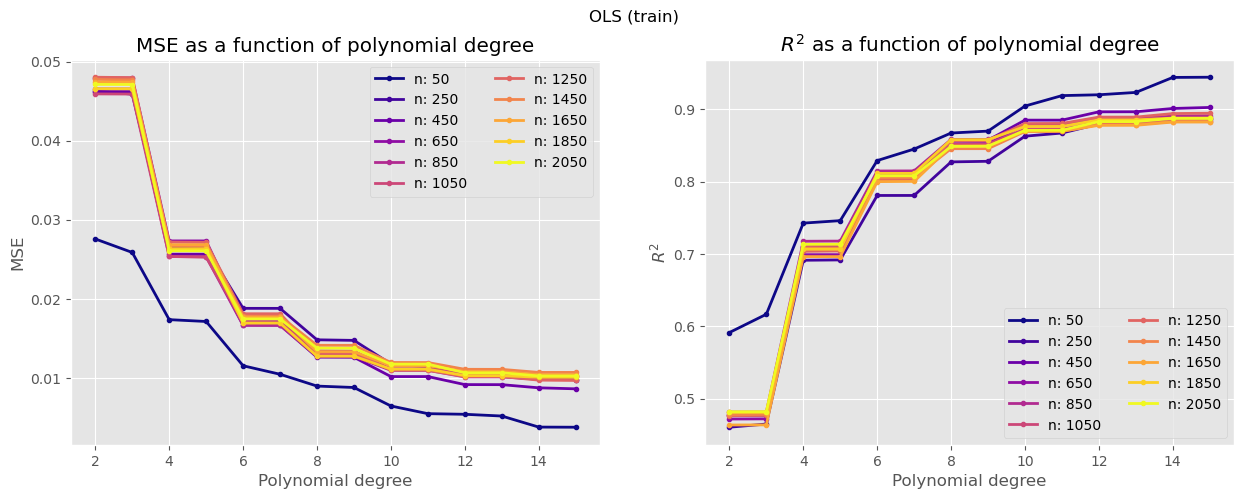

In [156]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

num_colors = len(n_vals)
cmap = plt.get_cmap(colormap, num_colors)

for i, en in enumerate(n_vals):
    n_df = df_OLS[df_OLS['n'] == en]
    color = cmap(i) 
    ax[0].plot(n_df['p'], n_df['MSE_train'], marker='o', markersize='3', linewidth='2', color=color, label=f'n: {en}')


ax[0].set_title('MSE as a function of polynomial degree')
ax[0].legend(loc='upper right', ncol=2)
ax[0].set_xlabel('Polynomial degree')
ax[0].set_ylabel('MSE')

for i, en in enumerate(n_vals):
    n_df = df_OLS[df_OLS['n'] == en]
    color = cmap(i) 
    ax[1].plot(n_df['p'], n_df['R2_train'], marker='o', markersize='3', linewidth='2', color=color, label=f'n: {en}')

ax[1].set_title(r'$R^2$ as a function of polynomial degree')
ax[1].legend(loc='lower right', ncol=2)
ax[1].set_xlabel('Polynomial degree')
ax[1].set_ylabel(r'$R^2$')

fig.suptitle('OLS (train)')

* Test/train lages for hver n, så polynom degree for en gitt n er sammenlignbar. 
* Her ser vi at MSE generelt blir lavere for høyere grads polynom. R^2 blir også bedre.

* Beste modell gitt dette? Man kan argumnetere for at MSE blir lavere med høyrere modell kompleksitet, men at det stagnerer noe ved høyere grader. Grad 6-8 optimalt? Eller?

Text(0.5, 0.98, 'OLS (train)')

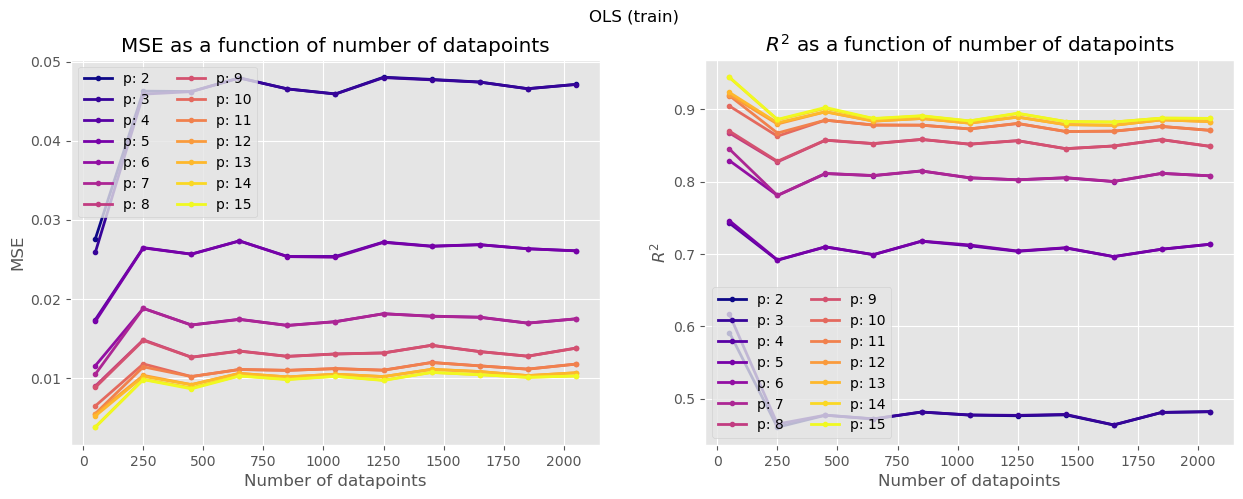

In [157]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

num_colors = len(p_vals)
cmap = plt.get_cmap(colormap, num_colors)

for i, pe in enumerate(p_vals):
    p_df = df_OLS[df_OLS['p'] == pe]
    color = cmap(i) 
    ax[0].plot(p_df['n'], p_df['MSE_train'], marker='o', markersize='3', linewidth='2', color=color, label=f'p: {pe}')

ax[0].set_title('MSE as a function of number of datapoints')
ax[0].legend(loc='upper left', ncol=2)
ax[0].set_xlabel('Number of datapoints')
ax[0].set_ylabel('MSE')

for i, pe in enumerate(p_vals):
    p_df = df_OLS[df_OLS['p'] == pe]
    color = cmap(i) 
    ax[1].plot(p_df['n'], p_df['R2_train'], marker='o', markersize='3', linewidth='2', color=color, label=f'p: {pe}')

ax[1].set_title(r'$R^2$ as a function of number of datapoints')
ax[1].legend(loc='lower left', ncol=2)
ax[1].set_xlabel('Number of datapoints')
ax[1].set_ylabel(r'$R^2$')

fig.suptitle('OLS (train)')

Text(0.5, 0.98, 'OLS (test)')

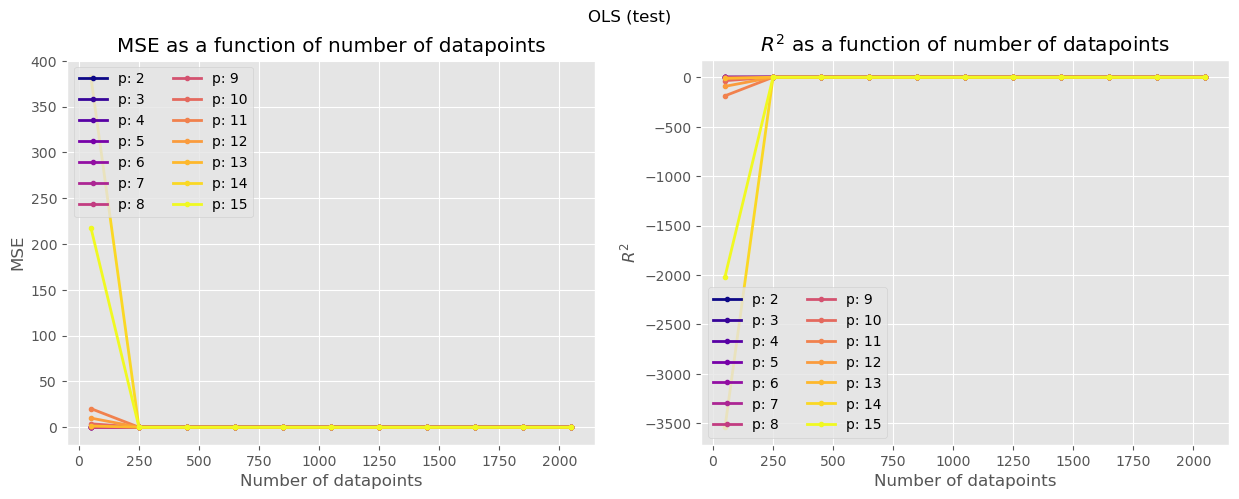

In [158]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

num_colors = len(p_vals)
cmap = plt.get_cmap(colormap, num_colors)

for i, pe in enumerate(p_vals):
    p_df = df_OLS[df_OLS['p'] == pe]
    color = cmap(i) 
    ax[0].plot(p_df['n'], p_df['MSE_test'], marker='o', markersize='3', linewidth='2', color=color, label=f'p: {pe}')

ax[0].set_title('MSE as a function of number of datapoints')
ax[0].legend(loc='upper left', ncol=2)
ax[0].set_xlabel('Number of datapoints')
ax[0].set_ylabel('MSE')

for i, pe in enumerate(p_vals):
    p_df = df_OLS[df_OLS['p'] == pe]
    color = cmap(i) 
    ax[1].plot(p_df['n'], p_df['R2_test'], marker='o', markersize='3', linewidth='2', color=color, label=f'p: {pe}')

ax[1].set_title(r'$R^2$ as a function of number of datapoints')
ax[1].legend(loc='lower left', ncol=2)
ax[1].set_xlabel('Number of datapoints')
ax[1].set_ylabel(r'$R^2$')

fig.suptitle('OLS (test)')

* Lavere grads polynomer er mest sensitive til antall datapunkter
* Toppene på 200, 600 og 900 er rare. Hvorfor skjer dette? Hadde forventa at det bare ble bedre og bedre med mer data, men kanskje de tilfeldige variablene klusser det til?

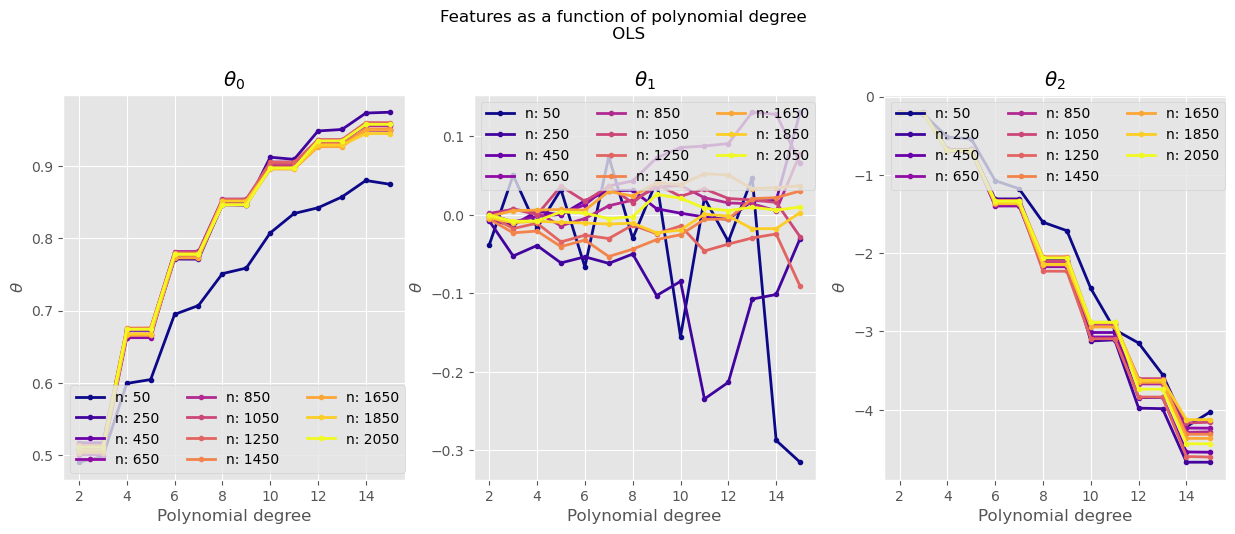

In [159]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

num_colors = len(n_vals)
cmap = plt.get_cmap(colormap, num_colors)

for i, en in enumerate(n_vals):
    n_df = df_OLS[df_OLS['n'] == en]
    color = cmap(i) 
    ax[0].plot(n_df['p'], n_df['theta'].apply(lambda x: x[0]), marker='o', markersize='3', linewidth='2', color=color, label=f'n: {en}')
    ax[1].plot(n_df['p'], n_df['theta'].apply(lambda x: x[1]), marker='o', markersize='3', linewidth='2', color=color, label=f'n: {en}')
    ax[2].plot(n_df['p'], n_df['theta'].apply(lambda x: x[2]), marker='o', markersize='3', linewidth='2', color=color, label=f'n: {en}')

ax[0].set_title(r'$\theta_0$')
ax[1].set_title(r'$\theta_1$')
ax[2].set_title(r'$\theta_2$')

fig.suptitle(f'Features as a function of polynomial degree \n OLS', y=1.05)

for axs in ax:
    axs.set_xlabel('Polynomial degree')
    axs.set_ylabel(r'$\theta$')

ax[0].legend(loc='lower left', ncol=3)
ax[1].legend(loc='upper left', ncol=3)
ax[2].legend(loc='upper left', ncol=3)

# b) Ridge regression
* Using Ridge regression to predict the Runge function.
* Method is applied for the different number of data points in `n_vals` and for the different polynomial degrees in `p_vals`, and for different values of the penalization parameter $\lambda$.
* Uses sklearn functionalities to make the model and assess the MSE and R^2 score.

In [160]:
lambdas = np.logspace(-8, 2, 15)

In [161]:
df_Ridge = Ridge_results(n_vals, p_vals, lambdas)

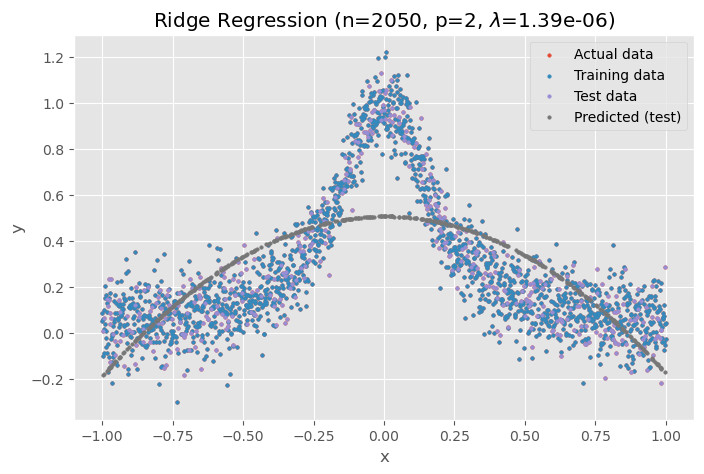

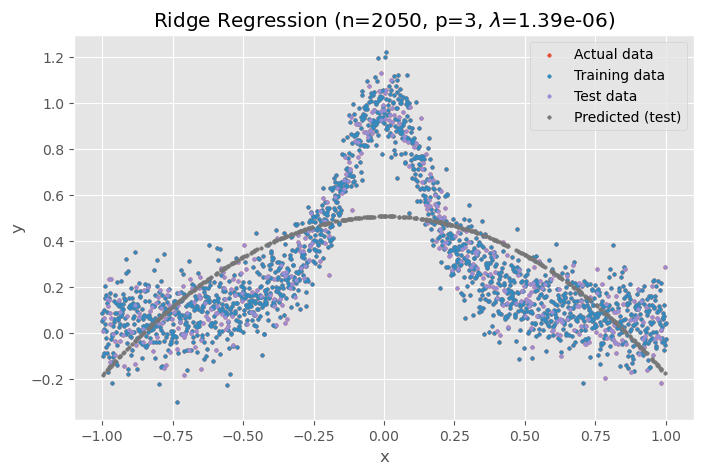

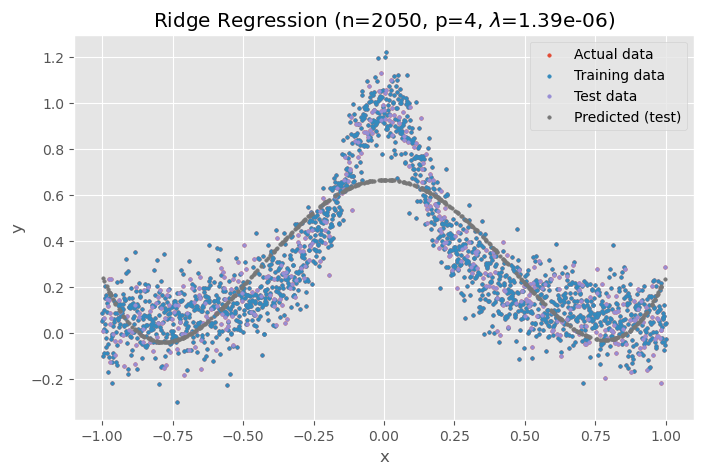

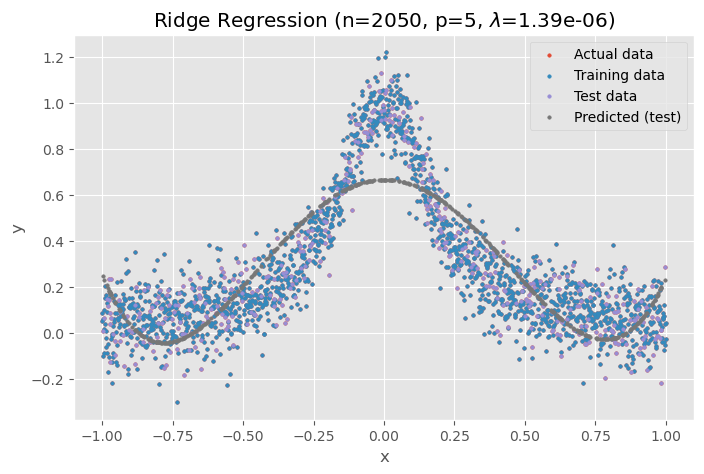

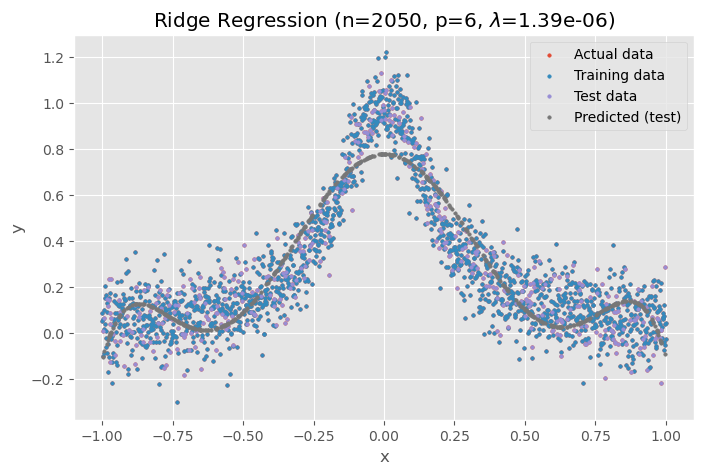

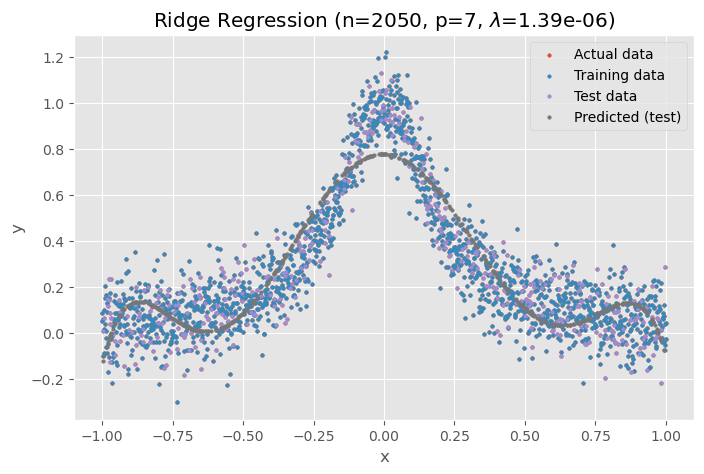

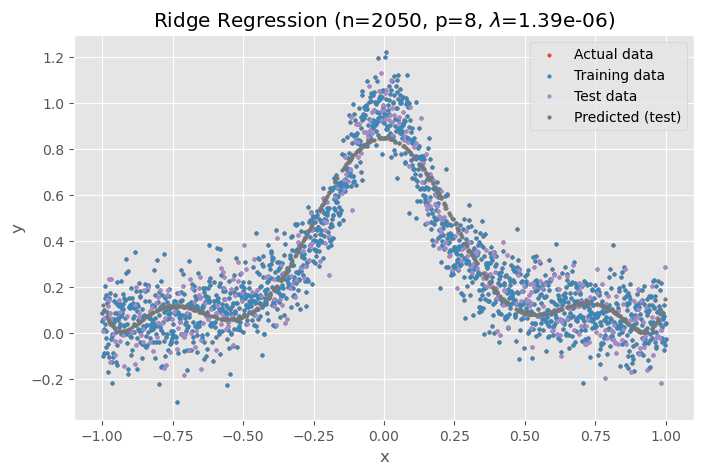

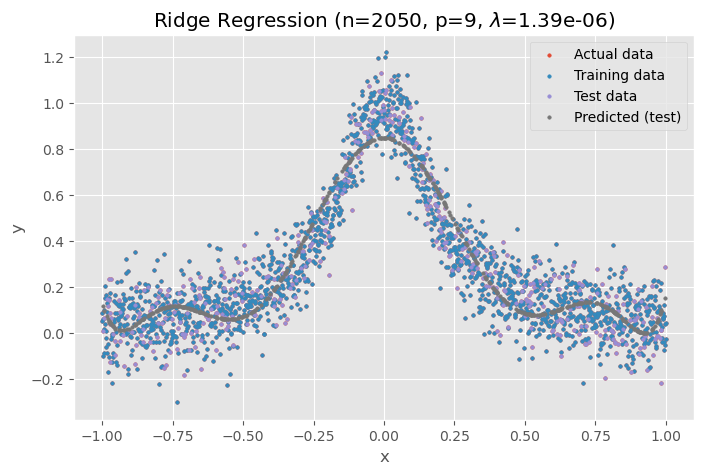

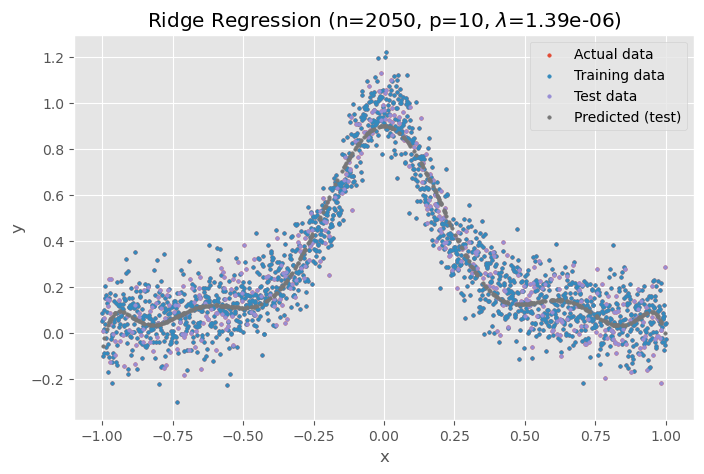

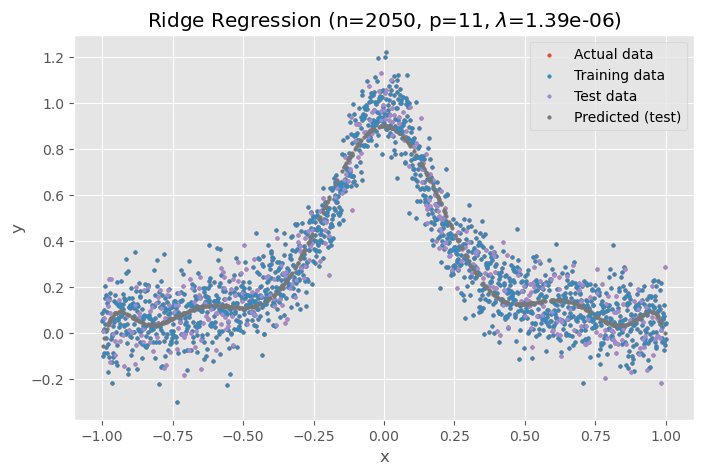

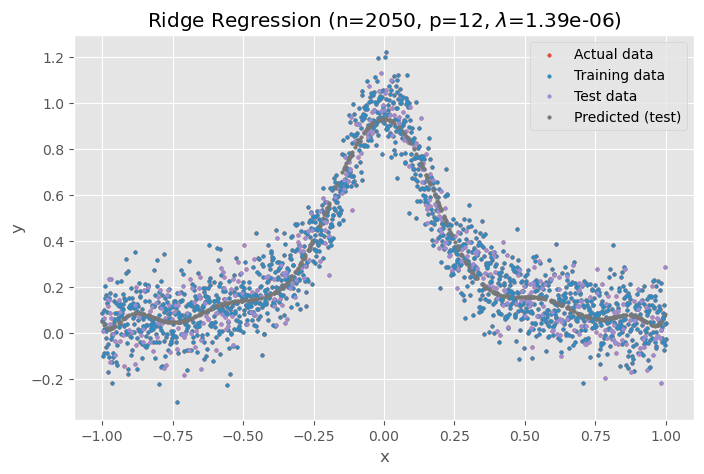

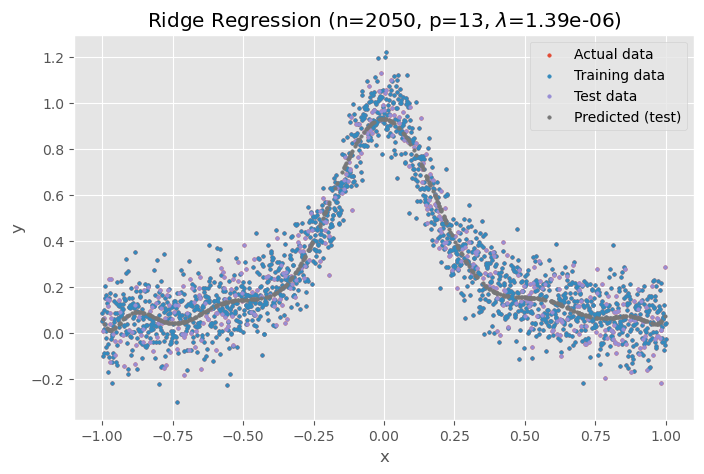

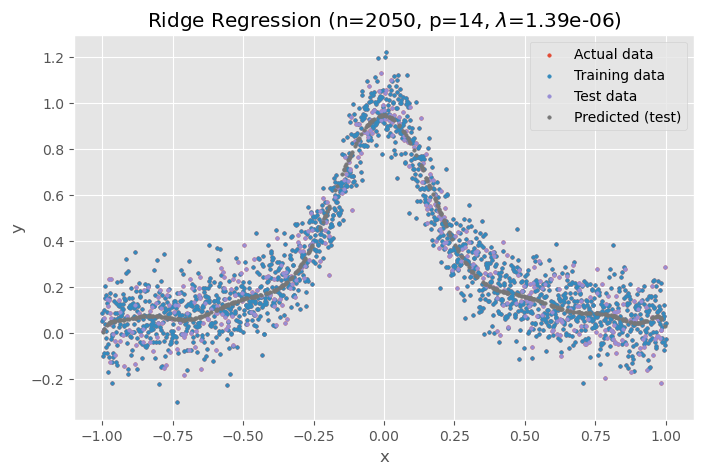

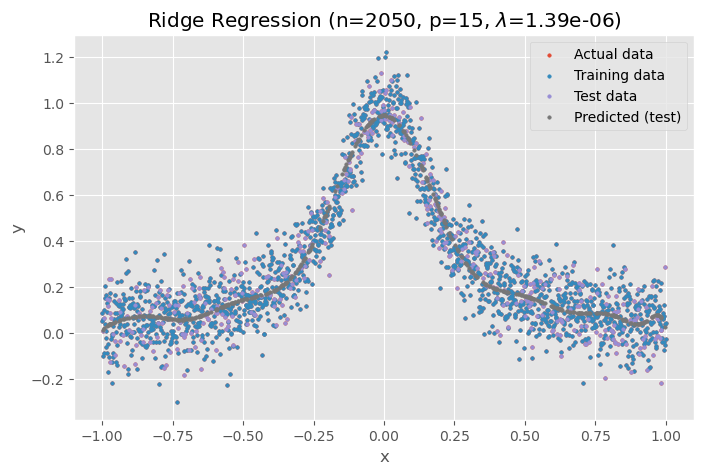

In [162]:
for p in p_vals:
    plot_Ridge_results(df_Ridge, n_vals[-1], p, lambdas[3])

Text(0.5, 0.98, 'Ridge \n Datapoints: 2050')

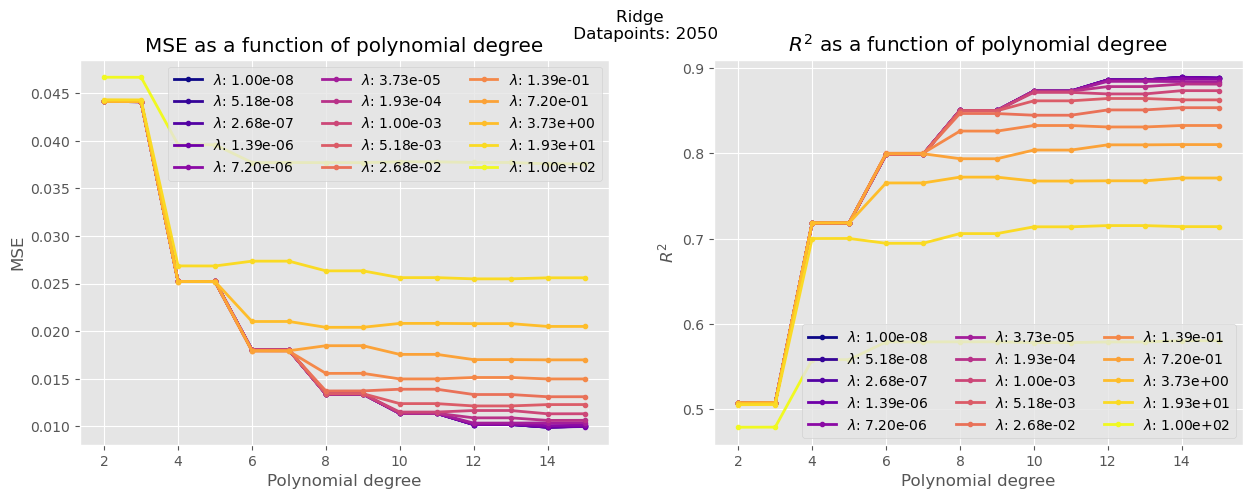

In [163]:
# Choosing a n-value to plot for
n_val = n_vals[-1]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

colormap='plasma'
num_colors = len(lambdas)
cmap = plt.get_cmap(colormap, num_colors)

for i, l in enumerate(lambdas):
    n_df = df_Ridge[(df_Ridge['lambda'] == l) & (df_Ridge['n'] == n_val)]
    color = cmap(i) 
    ax[0].plot(n_df['p'], n_df['MSE'], marker='o', markersize='3', linewidth='2', color=color, label=rf'$\lambda$: {l:.2e}')
    ax[1].plot(n_df['p'], n_df['R2'], marker='o', markersize='3', linewidth='2', color=color, label=rf'$\lambda$: {l:.2e}')

ax[0].set_title('MSE as a function of polynomial degree')
ax[0].legend(loc='upper right', ncol=3)
ax[0].set_xlabel('Polynomial degree')
ax[0].set_ylabel('MSE')

ax[1].set_title(r'$R^2$ as a function of polynomial degree')
ax[1].legend(loc='lower right', ncol=3)
ax[1].set_xlabel('Polynomial degree')
ax[1].set_ylabel(r'$R^2$')

fig.suptitle(f'Ridge \n Datapoints: {n_val}')

Text(0.5, 0.98, 'Ridge \n Datapoints: 2050')

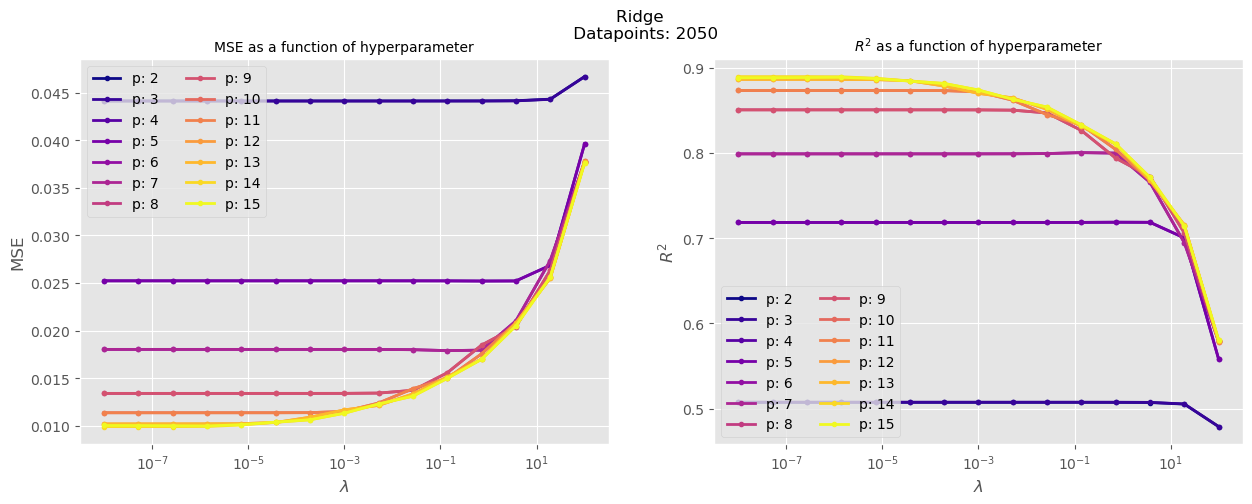

In [164]:
# Choosing a n-value to plot for
n_val = n_vals[-1]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

colormap='plasma'
num_colors = len(p_vals)
cmap = plt.get_cmap(colormap, num_colors)

for i, pe in enumerate(p_vals):
    n_df = n_df = df_Ridge[(df_Ridge['p'] == pe) & (df_Ridge['n'] == n_val)]
    color = cmap(i) 
    ax[0].plot(n_df['lambda'], n_df['MSE'], marker='o', markersize='3', linewidth='2', color=color, label=f'p: {pe:.0f}')
    ax[1].plot(n_df['lambda'], n_df['R2'], marker='o', markersize='3', linewidth='2', color=color, label=f'p: {pe:.0f}')

ax[0].set_title('MSE as a function of hyperparameter', fontsize=10)
ax[0].legend(loc='upper left', ncol=2)
ax[0].set_xlabel(r'$\lambda$')
ax[0].set_ylabel('MSE')

ax[1].set_title(r'$R^2$ as a function of hyperparameter', fontsize=10)
ax[1].legend(loc='lower left', ncol=2)
ax[1].set_xlabel(r'$\lambda$')
ax[1].set_ylabel(r'$R^2$')

ax[0].set_xscale('log')
ax[1].set_xscale('log')

fig.suptitle(f'Ridge \n Datapoints: {n_val}')

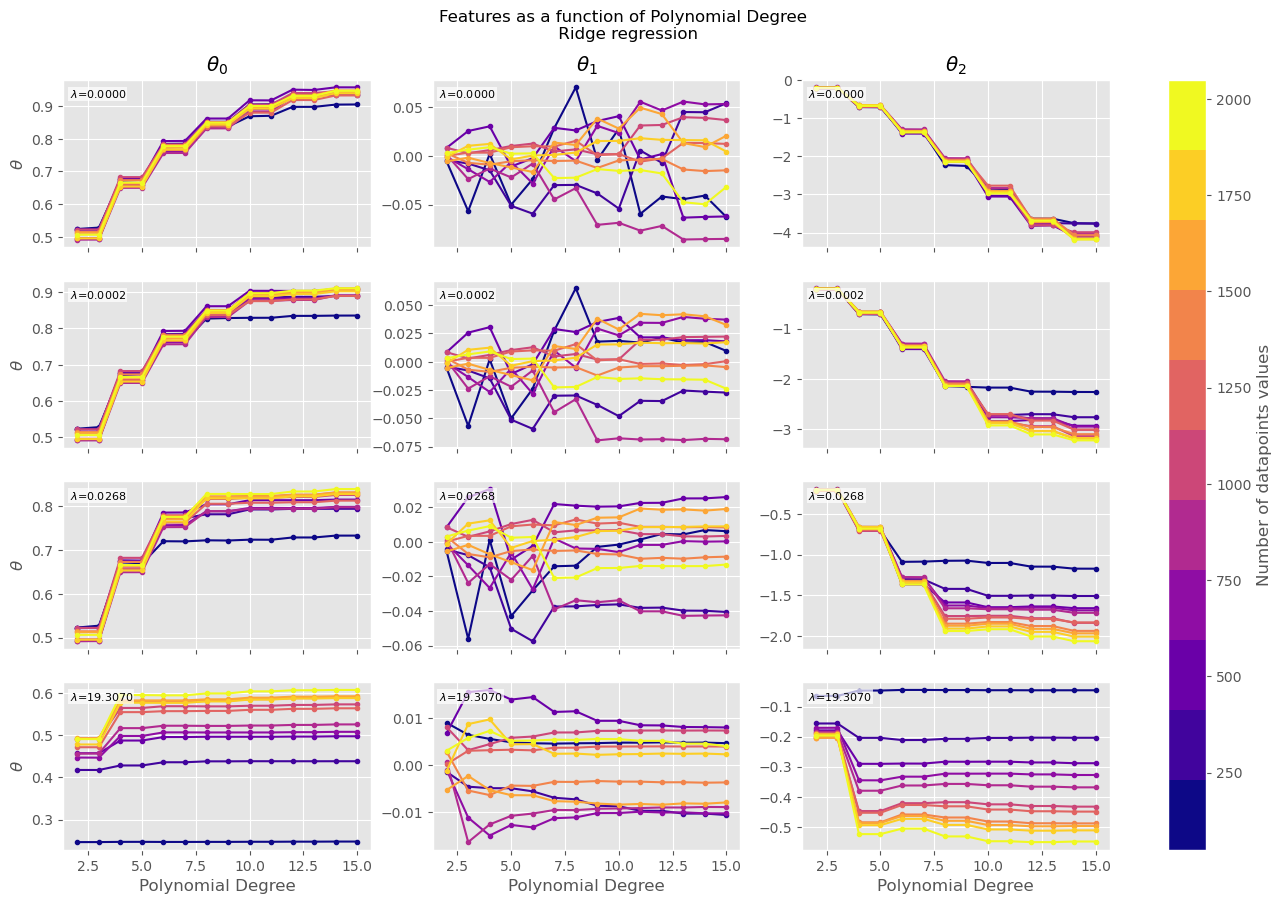

In [165]:
# Selecting specific lambda values to plot
lambda_subset = [lambdas[3], lambdas[6], lambdas[9], lambdas[13]]

fig, ax = plt.subplots(4, 3, figsize=(15, 10), sharex='col')
colormap = 'plasma'
num_colors = len(n_vals)
cmap = plt.get_cmap(colormap, num_colors)

for j, l_val in enumerate(lambda_subset):
    for i, en in enumerate(n_vals):
        n_df = df_Ridge[(df_Ridge['n'] == en) & (df_Ridge['lambda'] == l_val)]
        color = cmap(i)
        ax[j, 0].plot(
            n_df['p'], n_df['theta'].apply(lambda x: x[0]),
            marker='o', markersize=3, linewidth=1.5, color=color
        )
        ax[j, 1].plot(
            n_df['p'], n_df['theta'].apply(lambda x: x[1]),
            marker='o', markersize=3, linewidth=1.5, color=color
        )

        ax[j, 2].plot(
            n_df['p'], n_df['theta'].apply(lambda x: x[2]),
            marker='o', markersize=3, linewidth=1.5, color=color
        )

    ax[j, 0].text(
        0.02, 0.95, rf'$\lambda$={l_val:.4f}',
        transform=ax[j, 0].transAxes,
        fontsize=8, va='top', ha='left',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
    )
    ax[j, 1].text(
        0.02, 0.95, rf'$\lambda$={l_val:.4f}',
        transform=ax[j, 1].transAxes,
        fontsize=8, va='top', ha='left',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
    )

    ax[j, 2].text(
        0.02, 0.95, rf'$\lambda$={l_val:.4f}',
        transform=ax[j, 2].transAxes,
        fontsize=8, va='top', ha='left',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1)
    )

fig.suptitle('Features as a function of Polynomial Degree \n Ridge regression', y=0.95)

for axs in ax[:, 0]:
    axs.set_ylabel(r'$\theta$')

ax[0, 0].set_title(r'$\theta_0$')
ax[0, 1].set_title(r'$\theta_1$')
ax[0, 2].set_title(r'$\theta_2$')

ax[3, 0].set_xlabel('Polynomial Degree')
ax[3, 1].set_xlabel('Polynomial Degree')
ax[3, 2].set_xlabel('Polynomial Degree')

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(n_vals), vmax=max(n_vals)))
sm.set_array([])

cbar = fig.colorbar(
    sm, ax=ax.ravel().tolist(), orientation='vertical',
    fraction=0.05, pad=0.05, location='right'
)
cbar.set_label('Number of datapoints values')

#plt.tight_layout(rect=[0, 0.05, 1, 0.96])
